Getting all the imports

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
data = pd.read_csv('data/data-main.csv')
data

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,10090151,K07985.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,0,...,-166.0,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
9560,10128825,K07986.01,NaN,CANDIDATE,CANDIDATE,0.497,0,0,0,0,...,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757
9561,10147276,K07987.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.021,0,0,1,0,...,-236.0,4.447,0.056,-0.224,1.041,0.341,-0.114,294.16489,47.176281,15.385
9562,10155286,K07988.01,NaN,CANDIDATE,CANDIDATE,0.092,0,0,0,0,...,-128.0,2.992,0.030,-0.027,7.824,0.223,-1.896,296.76288,47.145142,10.998


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        2365 non-null   object 
 3   koi_disposition    9564 non-null   object 
 4   koi_pdisposition   9564 non-null   object 
 5   koi_score          8054 non-null   float64
 6   koi_fpflag_nt      9564 non-null   int64  
 7   koi_fpflag_ss      9564 non-null   int64  
 8   koi_fpflag_co      9564 non-null   int64  
 9   koi_fpflag_ec      9564 non-null   int64  
 10  koi_period         9564 non-null   float64
 11  koi_period_err1    9110 non-null   float64
 12  koi_period_err2    9110 non-null   float64
 13  koi_time0bk        9564 non-null   float64
 14  koi_time0bk_err1   9110 non-null   float64
 15  koi_time0bk_err2   9110 non-null   float64
 16  koi_impact         9201 

Data Preprocessing

In [4]:
def prep(df):
    df = df.copy()
    
    #drop unused columns
    df = df.drop(['kepid','kepoi_name','kepler_name','koi_pdisposition','koi_score'],axis=1)
    
    #limit target variable
    df['koi_disposition'] = df['koi_disposition'].apply(lambda x: 0 if x == 'FALSE POSITIVE' else 1)
    
    #drop cols entirely having null values
    df = df.drop(['koi_teq_err1','koi_teq_err2'],axis=1)
    
    #filling non numerical missing values using mode
    df['koi_tce_delivname'] = df['koi_tce_delivname'].fillna(df['koi_tce_delivname'].mode()[0])
    
    #for filling numerical empty values
    for col in df.columns[df.isna().sum() > 0] :
        df[col] = df[col].fillna(df[col].mean())
    
    #since we have a categorical column, encoding it to numerical form
    delivname_dummies = pd.get_dummies(df['koi_tce_delivname'], prefix='delivname')
    df = pd.concat([df, delivname_dummies], axis=1)
    df = df.drop('koi_tce_delivname', axis=1)
    
    #splitting the train & test data set
    y = df['koi_disposition']
    x = df.drop(['koi_disposition'],axis=1)
    #random state is seed that ensure that every time we get the same random set
    x_train , x_test , y_train , y_test = train_test_split(x, y, train_size=0.7 , random_state = 1, shuffle=True)
    
    return x_train , x_test , y_train , y_test

In [5]:
#rough work
# DF = prep(data)
# DF.isna().sum() > 0 #this will return the list of all the columns that have any null values
# DF.info()

# 'x' are features & 'y' is target
x_train , x_test , y_train , y_test = prep(data)

# x_test.shape
# y_test.shape

In [6]:
#normalising the data
scaler = MinMaxScaler()
x_train_norm = x_train.copy()
x_test_norm = x_test.copy()

scaler.fit(x_train_norm)
x_train_norm = pd.DataFrame(scaler.transform(x_train_norm) , index=x_train_norm.index , columns = x_train_norm.columns)
x_test_norm = pd.DataFrame(scaler.transform(x_test_norm) , index=x_test_norm.index , columns = x_test_norm.columns)

x_test_norm.head()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,...,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,delivname_q1_q16_tce,delivname_q1_q17_dr24_tce,delivname_q1_q17_dr25_tce
9066,0.000000,0.0,0.0,1.0,0.000316,0.000097,0.999903,0.008188,0.031330,0.968670,...,0.854184,0.003172,0.008476,0.999371,0.564436,0.703369,0.691647,0.0,0.0,1.0
3891,0.002151,0.0,1.0,0.0,0.000662,0.003393,0.996607,0.009184,0.012868,0.987132,...,0.881391,0.003877,0.013958,0.996601,0.658407,0.115927,0.459001,0.0,0.0,1.0
4905,0.000000,1.0,0.0,0.0,0.025939,0.000098,0.999902,0.032353,0.000466,0.999534,...,0.867440,0.003281,0.008360,0.999303,0.342817,0.108427,0.688042,0.0,0.0,1.0
5835,0.000000,0.0,1.0,1.0,0.000753,0.000135,0.999865,0.008985,0.024022,0.975978,...,0.900580,0.003412,0.004623,0.999561,0.480098,0.087012,0.532715,0.0,0.0,1.0
218,0.000000,0.0,0.0,0.0,0.005150,0.000055,0.999945,0.008471,0.001329,0.998671,...,0.975145,0.005666,0.003506,0.999371,0.211712,0.496278,0.412672,0.0,0.0,1.0


In [7]:
#standardising the data
scaler = StandardScaler()
x_train_stand = x_train.copy()
x_test_stand = x_test.copy()

scaler.fit(x_train_stand)
x_train_stand = pd.DataFrame(scaler.transform(x_train_stand) , index=x_train_stand.index , columns = x_train_stand.columns)
x_test_stand = pd.DataFrame(scaler.transform(x_test_stand) , index=x_test_stand.index , columns = x_test_stand.columns)

x_test_stand.head()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,...,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,delivname_q1_q16_tce,delivname_q1_q17_dr24_tce,delivname_q1_q17_dr25_tce
9066,-0.040699,-0.550310,-0.498179,2.718174,-0.485092,-0.277511,0.277511,-0.509315,0.298127,-0.298127,...,-0.390354,-0.147956,-0.165777,0.148408,0.027682,1.064594,1.244772,-0.301855,-0.198191,0.371548
3891,0.134956,-0.550310,2.007312,-0.367894,-0.479169,-0.203198,0.203198,-0.489792,-0.147004,0.147004,...,0.000326,-0.121423,-0.000206,0.001880,0.456691,-1.498271,-0.943032,-0.301855,-0.198191,0.371548
4905,-0.040699,1.817156,-0.498179,-0.367894,-0.046258,-0.277485,0.277485,-0.035639,-0.446030,0.446030,...,-0.200008,-0.143861,-0.169268,0.144765,-0.984083,-1.530993,1.210869,-0.301855,-0.198191,0.371548
5835,-0.040699,-0.550310,2.007312,2.718174,-0.477605,-0.276651,0.276651,-0.493697,0.121929,-0.121929,...,0.275858,-0.138948,-0.282137,0.158425,-0.357348,-1.624422,-0.249831,-0.301855,-0.198191,0.371548
218,-0.040699,-0.550310,-0.498179,-0.367894,-0.402297,-0.278469,0.278469,-0.503771,-0.425211,0.425211,...,1.346557,-0.054109,-0.315882,0.148408,-1.582622,0.161105,-1.378717,-0.301855,-0.198191,0.371548


In [8]:
#checking the distribution of data
y_train.value_counts()

0    3410
1    3284
Name: koi_disposition, dtype: int64

Model Training and Evaluation

In [9]:
#creating evaluation function
#y_test --> actual values
#y_pred --> our values

def get_results(y_test,y_pred,positive_label=1):
    tp = 0 #true and predicted true
    fn = 0 # true but predicted false
    fp = 0 # false but predicted true
    tn = 0 # false and predicted false
    
    for y_t, y_p in zip(y_test, y_pred):
        if y_t == positive_label:
            if y_p == positive_label:
                tp += 1
            else:
                fn += 1
        else:
            if y_p == positive_label:
                fp += 1
            else:
                tn += 1
    
    return tp, fn, fp, tn

def get_accuracy(tp, fn, fp, tn):
    acc = (tp + tn) / (tp + fn + fp + tn)
    return acc

def get_precision(tp, fn, fp, tn):
    precision = tp / (tp + fp)
    return precision

def get_recall(tp, fn, fp, tn):
    recall = tp / (tp + fn)
    return recall

def get_f1_score(tp, fn, fp, tn):
    precision = get_precision(tp, fn, fp, tn)
    recall = get_recall(tp, fn, fp, tn)
    f1_score = (2 * precision * recall) / (precision + recall)
    return f1_score

Decision Tree training and results for raw data


Accuracy is 0.9846689895470383
Precision is 0.9847222222222223
Recall is 0.9847222222222223
F1 Score is 0.9847222222222223

Decision Tree training and results for normalized data data


Accuracy is 0.9853658536585366
Precision is 0.9854166666666667
Recall is 0.9854166666666667
F1 Score is 0.9854166666666667

Decision Tree training and results for standardized data


Accuracy is 0.9860627177700348
Precision is 0.9867872044506258
Recall is 0.9854166666666667
F1 Score is 0.9861014593467687
Decision Tree model trained!


Logistic Regression training and results for raw data


Accuracy is 0.7585365853658537
Precision is 0.7380497131931166
Recall is 0.8041666666666667
F1 Score is 0.7696909272183449

Logistic Regression training and results for normalized data data


Accuracy is 0.8961672473867596
Precision is 0.860479797979798
Recall is 0.9465277777777777
F1 Score is 0.9014550264550265

Logistic Regression training and results for standardize

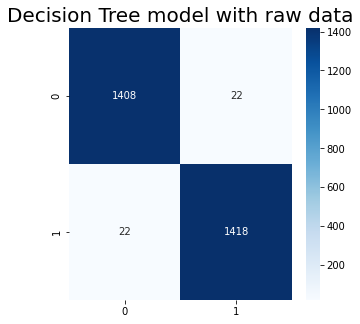

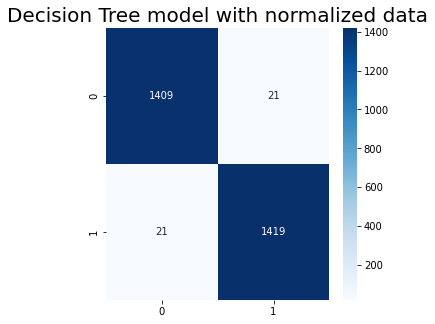

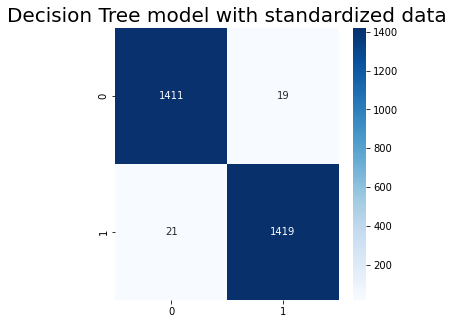

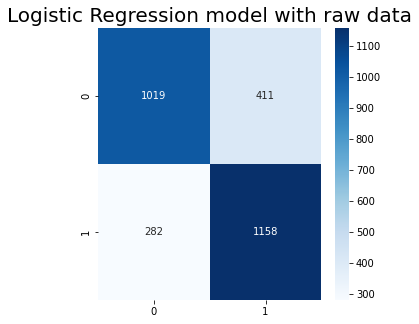

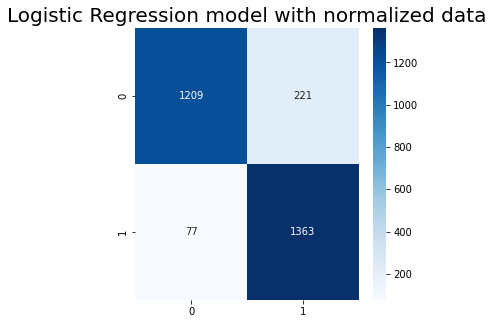

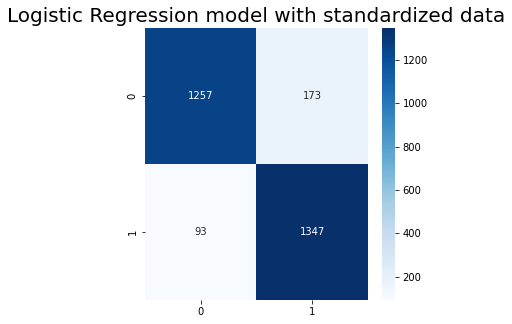

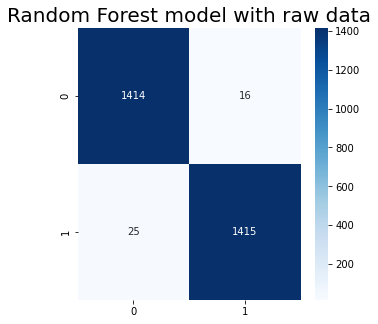

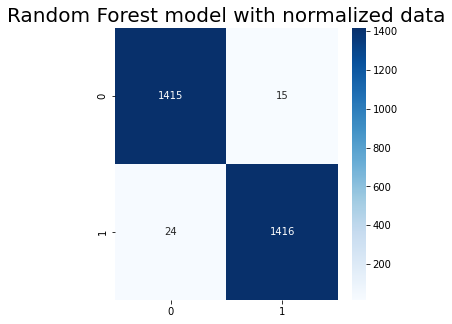

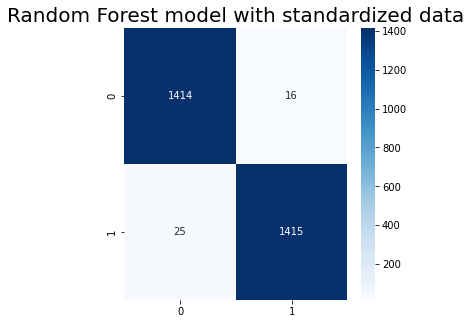

In [13]:
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
}

results = []
names = []

for name,model in models.items():
    #RAW
    print(f'{name} training and results for raw data')
    #train the model
    model.fit(x_train,y_train)
    #test/predict from model
    y_pred = model.predict(x_test)
    #evaluate the results
    tp,fn,fp,tn = get_results(y_test,y_pred)
    #create a new dataframe for making confusion matrix
    df_cf = pd.DataFrame([[tn,fp],[fn,tp]],range(2), range(2))

    plt.figure(figsize = (5,5))
    plt.title(f"{name} model with raw data",fontsize=20)
    sns.heatmap(df_cf , annot=True , cmap='Blues' , fmt='d')

    print('\n')
    print(f'Accuracy is {get_accuracy(tp,fn,fp,tn)}')
    print(f'Precision is {get_precision(tp,fn,fp,tn)}')
    print(f'Recall is {get_recall(tp,fn,fp,tn)}')
    print(f'F1 Score is {get_f1_score(tp,fn,fp,tn)}\n')

    #NORM
    print(f'{name} training and results for normalized data data')
    model.fit(x_train_norm,y_train)
    y_pred = model.predict(x_test_norm)
    tp,fn,fp,tn = get_results(y_test,y_pred)
    df_cf = pd.DataFrame([[tn,fp],[fn,tp]],range(2), range(2))
    plt.figure(figsize = (5,5))
    plt.title(f"{name} model with normalized data",fontsize=20)
    sns.heatmap(df_cf , annot=True , cmap='Blues' , fmt='d')
    print('\n')
    print(f'Accuracy is {get_accuracy(tp,fn,fp,tn)}')
    print(f'Precision is {get_precision(tp,fn,fp,tn)}')
    print(f'Recall is {get_recall(tp,fn,fp,tn)}')
    print(f'F1 Score is {get_f1_score(tp,fn,fp,tn)}\n')
   
    #STAND
    print(f'{name} training and results for standardized data')
    model.fit(x_train_stand,y_train)
    y_pred = model.predict(x_test_stand)
    tp,fn,fp,tn = get_results(y_test,y_pred)
    df_cf = pd.DataFrame([[tn,fp],[fn,tp]],range(2), range(2))
    plt.figure(figsize = (5,5))
    plt.title(f"{name} model with standardized data",fontsize=20)
    sns.heatmap(df_cf , annot=True , cmap='Blues' , fmt='d')
    print('\n')
    print(f'Accuracy is {get_accuracy(tp,fn,fp,tn)}')
    print(f'Precision is {get_precision(tp,fn,fp,tn)}')
    print(f'Recall is {get_recall(tp,fn,fp,tn)}')
    print(f'F1 Score is {get_f1_score(tp,fn,fp,tn)}')
    results.append(get_accuracy(tp,fn,fp,tn))
    names.append(name)
    print(f'{name} model trained!\n\n')

    # 00->TN    01->FP  10->FN  11->TP

Picking the choosen model
We have choosen Decision Tree Model with standardised data.

In [31]:
model = DecisionTreeClassifier()
model.fit(x_train_stand,y_train)
tp,fn,fp,tn = get_results(y_test,model.predict(x_test_stand))
print(get_accuracy(tp,fn,fp,tn))
#accuracy=0.98606
# pickle_out = open("my_model.pickle","wb")
# pickle.dump(model,pickle_out)
# pickle_out.close()

0.98397212543554


In [36]:
pickle_in = open("my_model.pickle","rb")
trained_model = pickle.load(pickle_in)
tp,fn,fp,tn = get_results(y_test,trained_model.predict(x_test_stand))
print(get_accuracy(tp,fn,fp,tn))

0.9850174216027875
